<a href="https://colab.research.google.com/github/putrinahampun/final-project-scAI5/blob/main/Egg_Grading_Automation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**FINAL PROJECT STARTUP CAMPUS AI BATCH 5** 🚀✨
###By: 404 *NOT* ALWAYS FOUND

---

📌 **Project's Name** : *Egg Grading Automation: Quality Classification Based on its External Property (Shell Color) Using ResNet-18* 🥚🎊

💫 **Topic** : Image Classification

🖼️ **Background** :  
Egg is a primary source of protein and possess high nutritional value. The relatively low cost of eggs makes them the fourth most consumed commodity among the Indonesian population (BPS, 2021). Eggs vary in quality and are categorized into three grades according to the Indonesian National Standard (SNI): **Grade A, B, and C**. One observable factor used to classify egg quality is the **"egg color"**. However, in some cases, such as with egg vendors, egg classification is still done manually, leading to time-consuming processes. Additionally, consumers often rely solely on egg size when making purchases, despite the fact that egg size may not necessarily reflect egg quality.

🎯 **Target**:
This project aims to develop a system that can automatically grade eggs into three quality categories, namely Grade A, B, and C, in accordance with the Indonesian National Standard (SNI) based on **egg color**.

🪄 **Dataset**:
*   The dataset used consists of images of 'Telur Ayam Ras' collected manually using a smartphone camera.
*   The collected dataset comprises 600 egg images, with each quality category containing 200 eggs (Grade A, B, and C).
*   Egg Color Criteria:
    * Grade A: Brown
    * Grade B: Light Brown
    * Grade C: Off-White Brown
*   Link Dataset: https://drive.google.com/drive/folders/1--F2ivjU88cwfi_5Xko7VKb_V1QuAug7?usp=sharing


📝 **Modelling**:
*   The architecture used for the model is **ResNet-18** with randomly initialized weights and biases (pretrained=False). Additional layers have been added to modify the model.
*   Parameters used:
    * Batch Size : 64
    * Learning Rate : 0.0001
    * Epoch : 100
*   Training Data 80%, Validation Data 20%, Testing Data 10%
*   Performing Augmentation Process : Random Horizontal and Vertical Flip

📈 **Result**:
*   Testing Dataset:
    * Accuracy  : 91.67%
    * Precision : 0.93
    * Recall    : 0.9167
*   Testing 10 images (out of dataset):
    * Accuracy  : 93%
    * Precision : 0.94
    * Recall    : 0.93






## Modules And Settings

### **Modules**
These codes contain all the imported modules required for this project.

In [ ]:
import torch, torchvision, time
import torchvision.transforms as transforms
import seaborn as sns
import numpy as np
import copy
import os

from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, accuracy_score
from warnings import filterwarnings as fw; fw("ignore")
from torch.utils.data import DataLoader, ConcatDataset
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm
from google.colab import drive
from copy import deepcopy

### **Settings**
The provided code below sets the random seed for PyTorch and NumPy to ensure reproducibility of the results in a CUDA (GPU) environment by fixing the random number generation.

In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

np.random.seed(0)

This code below defines a function, check_params, which takes a PyTorch model as input and returns a dictionary containing the total number of trainable and non-trainable parameters in the model.

In [ ]:
def check_params(model, *args, **kwargs) -> dict:
    return {
        "total_trainable_params" : sum(p.numel() for p in model.parameters() if p.requires_grad),
        "total_nontrainable_params" : sum(p.numel() for p in model.parameters() if not p.requires_grad)
    }

This code below defines a training function (`fit`) for a PyTorch model using the Adam optimizer and CrossEntropyLoss for multi-classification tasks. It performs training and validation loops over a specified number of epochs, tracks accuracy and loss, and returns a dictionary containing model information and performance metrics.

In [ ]:
def fit(
    model : torchvision.models,
    epoch : int,
    train_loader : torch.utils.data.DataLoader,
    val_loader : torch.utils.data.DataLoader,
    *args, **kwargs
) -> dict:

    loss_function = torch.nn.CrossEntropyLoss() # Define the loss function (for multi-classification)

    trainable_model_params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(trainable_model_params, lr=LEARNING_RATE)

    TRAIN_LOSS, TRAIN_ACC = [], []
    train_batches = len(train_loader)

    VAL_LOSS, VAL_ACC = [], []
    val_batches = len(val_loader)

    # loop for every epoch (training + evaluation)
    start_ts = time.time()
    for e in range(epoch):
        train_losses = 0
        train_accuracies = 0

        # progress bar
        progress = tqdm(enumerate(train_loader), desc="Loss: ", total=train_batches)

        # ----------------- TRAINING  --------------------
        # set model to training
        model.train()

        for i, data in progress:
            X, y = data[0].to(device), data[1].to(device)

            # training step for single batch
            model.zero_grad()

            # forward pass
            outputs = model(X)
            loss = loss_function(outputs, y)

            # backward pass
            loss.backward()
            optimizer.step()

            train_losses += loss.item()

            ps = torch.exp(outputs)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == y.view(*top_class.shape)
            train_accuracies += torch.mean(equals.type(torch.FloatTensor)).item()

            # updating progress bar
            progress.set_description("Loss: {:.4f}".format(train_losses/(i+1)))

        TRAIN_ACC.append(train_accuracies/train_batches)
        TRAIN_LOSS.append(train_losses/train_batches)

        # releasing unceseccary memory in GPU
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        # ----------------- VALIDATION  -----------------
        val_losses = 0
        val_accuracies = 0

        # set model to evaluating (testing)
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                X, y = data[0].to(device), data[1].to(device)
                outputs = model(X) # this gives the prediction from the network
                val_losses += loss_function(outputs, y).item()

                ps = torch.exp(outputs)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == y.view(*top_class.shape)
                val_accuracies += torch.mean(equals.type(torch.FloatTensor)).item()

        print("Epoch {}/{} >> Training loss: {:.3f}, Validation loss: {:.3f}, Validation accuracy: {:.3f}".format(
            e+1, epoch, train_losses/train_batches, val_losses/val_batches, val_accuracies/val_batches*100)
        )

        VAL_ACC.append(val_accuracies/val_batches)
        VAL_LOSS.append(val_losses/val_batches)

    tr_time = time.time()-start_ts
    print("Training time: {:.3f}s".format(tr_time))

    return {
        "model" : model.name,
        "train_acc" : TRAIN_ACC,
        "train_loss" : TRAIN_LOSS,
        "val_acc" : VAL_ACC,
        "val_loss" : VAL_LOSS,
        "exc_time" : tr_time
    }

This code below defines a function, `plot_performance`, to visualize the training and validation loss as well as training and validation accuracy over epochs using matplotlib. The function takes a dictionary (`dict_`) containing these performance metrics and plots them in two subplots for loss and accuracy, providing insights into the model's training progress.

In [ ]:
def plot_performance(dict_ : dict, *args, **kwargs) -> None:
    my_figure = plt.figure(figsize=(12, 4))
    # NOTE: figsize=(width/horizontally, height/vertically)

    m = my_figure.add_subplot(121)
    plt.plot(dict_["train_loss"], label="Train Loss")
    plt.plot(dict_["val_loss"], label="Valid. Loss")
    plt.title("LOSS")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend(loc="best")

    n = my_figure.add_subplot(122)
    plt.plot(dict_["train_acc"], label="Train Accuracy")
    plt.plot(dict_["val_acc"], label="Valid. Accuracy")
    plt.title("ACCURACY")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend(loc="best")

    plt.tight_layout()
    plt.show()

## Load Dataset

This code used to mount the Google Drive in the directory ("/content/gdrive"). This allows access to files and data stored on Google Drive within the Colab environment.

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


These codes below is used to unzip the 'dataset.zip','data-testing.zip' and 'data-10-testing.zip' files stored in the Google Drive location ("/content/gdrive/MyDrive/All-File-ZIP/") in order to extract its contents.
*   dataset.zip : contains 600 image files for training categorized based on its quality.
*   data-testing.zip : contains 60 image files for testing categorized based on its quality.
*   data-10-testing.zip : contains 10 image files (out of dataset)





In [ ]:
!unzip '/content/gdrive/MyDrive/All-File-ZIP/dataset.zip'

Archive:  /content/gdrive/MyDrive/All-File-ZIP/dataset.zip
  inflating: Dataset/Mutu C/_154.jpg  
  inflating: Dataset/Mutu C/_145.jpg  
  inflating: Dataset/Mutu C/_164.jpg  
  inflating: Dataset/Mutu C/_147.jpg  
  inflating: Dataset/Mutu C/_160.jpg  
  inflating: Dataset/Mutu C/_137.jpg  
  inflating: Dataset/Mutu C/_146.jpg  
  inflating: Dataset/Mutu C/_144.jpg  
  inflating: Dataset/Mutu C/_142.jpg  
  inflating: Dataset/Mutu C/_157.jpg  
  inflating: Dataset/Mutu C/_162.jpg  
  inflating: Dataset/Mutu C/_82.jpg  
  inflating: Dataset/Mutu C/_155.jpg  
  inflating: Dataset/Mutu C/_135.jpg  
  inflating: Dataset/Mutu C/_150.jpg  
  inflating: Dataset/Mutu C/_83.jpg  
  inflating: Dataset/Mutu C/_138.jpg  
  inflating: Dataset/Mutu C/_165.jpg  
  inflating: Dataset/Mutu C/_139.jpg  
  inflating: Dataset/Mutu C/_98.jpg  
  inflating: Dataset/Mutu C/_94.jpg  
  inflating: Dataset/Mutu C/_81.jpg  
  inflating: Dataset/Mutu C/_152.jpg  
  inflating: Dataset/Mutu C/_158.jpg  
  inflatin

In [ ]:
!unzip '/content/gdrive/MyDrive/All-File-ZIP/data-testing.zip'

Archive:  /content/gdrive/MyDrive/All-File-ZIP/data-testing.zip
  inflating: Testing/Mutu C/C15.jpg  
  inflating: Testing/Mutu B/b2(1).jpg  
  inflating: Testing/Mutu B/b10.jpg  
  inflating: Testing/Mutu C/C10.jpg  
  inflating: Testing/Mutu B/IMG_20231022_120137.jpg  
  inflating: Testing/Mutu B/B3.jpg   
  inflating: Testing/Mutu B/b4(1).jpg  
  inflating: Testing/Mutu C/C11.jpg  
  inflating: Testing/Mutu C/C14.jpg  
  inflating: Testing/Mutu B/IMG_20231022_120108.jpg  
  inflating: Testing/Mutu C/C16.jpg  
  inflating: Testing/Mutu B/B2.jpg   
  inflating: Testing/Mutu B/IMG_20231022_120430.jpg  
  inflating: Testing/Mutu B/IMG_20231022_120247.jpg  
  inflating: Testing/Mutu C/C5.jpg   
  inflating: Testing/Mutu A/A4.jpg   
  inflating: Testing/Mutu C/C8.jpg   
  inflating: Testing/Mutu B/b8.jpg   
  inflating: Testing/Mutu B/IMG_20231022_120058.jpg  
  inflating: Testing/Mutu B/B5.jpg   
  inflating: Testing/Mutu B/IMG_20231022_120103.jpg  
  inflating: Testing/Mutu B/b1.jpg   


In [ ]:
!unzip '/content/gdrive/MyDrive/All-File-ZIP/data-10-testing.zip'

Archive:  /content/gdrive/MyDrive/All-File-ZIP/data-10-testing.zip
  inflating: Testing dari internet/Mutu B/the-instagram-egg-1024x683.jpg  
  inflating: Testing dari internet/Mutu C/Screenshot 2023-11-23 071333.jpg  
  inflating: Testing dari internet/Mutu B/7a126d8b9c171f29a88a15ea222f4e27.jpg  
  inflating: Testing dari internet/Mutu B/Screenshot 2023-11-23 071852.jpg  
  inflating: Testing dari internet/Mutu A/4.jpg  
  inflating: Testing dari internet/Mutu A/images.jpg  
  inflating: Testing dari internet/Mutu C/pale-egg-against-blue-adrian-burke.jpg  
  inflating: Testing dari internet/Mutu C/Untitled.jpg  
  inflating: Testing dari internet/Mutu A/2.jpg  
  inflating: Testing dari internet/Mutu C/Screenshot 2023-11-17 213756.jpg  
  inflating: Testing dari internet/Mutu A/Screenshot 2023-11-23 215431.jpg  
  inflating: Testing dari internet/Mutu B/1.jpg  
  inflating: Testing dari internet/Mutu A/Screenshot 2023-11-23 072241.jpg  
  inflating: Testing dari internet/Mutu B/image

## Image Pre-processing

This code below defines variable base_dataset for saving the path of dataset location

In [ ]:
base_dataset = '/content/Dataset'

These codes below is used for resizing data to 300 x 300 pixels and converting data to tensor form.

In [ ]:
transform = transforms.Compose([ transforms.Resize((300,300)), transforms.ToTensor() ])
dataset = datasets.ImageFolder( root = base_dataset, transform = transform)

This code below calculates the mean and standard deviation (std) of the entire dataset by loading it using a PyTorch DataLoader with a batch size equal to the dataset size. It is used for normalizing the input data during preprocessing in machine learning models.

In [ ]:
loader = torch.utils.data.DataLoader( dataset,
                                      batch_size = len(dataset),
                                      num_workers = 1 )
data = next(iter(loader))
mean = data[0].mean(dim=(0, 2, 3))
std  = data[0].std(dim=(0, 2, 3))

print("Mean:", mean)
print("Std:", std)

Mean: tensor([0.6750, 0.6106, 0.5683])
Std: tensor([0.1580, 0.1903, 0.2257])


In [ ]:
custom_transform = transforms.Compose([ transforms.Resize((300, 300)),
                                        transforms.ToTensor(),
                                        torchvision.transforms.Normalize( mean=mean, std=std) ])

custom_dataset = ImageFolder( root=base_dataset, transform=custom_transform )

This code below shows the augmentation process.

In [ ]:
aug_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    torchvision.transforms.Normalize( mean=mean, std=std )
])

This code below is used for splitting the dataset into training (80%) and validation data (20%)

In [ ]:
train_dataset, val_dataset = train_test_split( custom_dataset,
                                               test_size = 0.2,
                                               random_state = 0 )

This code creates an augmented training dataset by using the 'aug_transform' to the original training dataset (`train_dataset`). The augmented samples are then combined with the original samples to form a new training dataset (`train_dataset_new`).

In [ ]:
train_aug_dataset = copy.copy(train_dataset)
train_aug_trans_dataset = [( aug_transform(item[0]), item[1]) for item in train_aug_dataset]
train_dataset_new = ConcatDataset([train_dataset, train_aug_trans_dataset])

## Modelling

These codes defines required parameters for modelling

In [ ]:
BATCH_SIZE = 64
EPOCH = 100
LEARNING_RATE = 0.0001

This code initializes two data loaders, `train_loader` and `val_loader`, for training and validation datasets, respectively. The data loaders facilitate the iteration over batches of data during the training and validation processes, with specified batch sizes and shuffle settings.

In [ ]:
train_loader = DataLoader( train_dataset_new,
                           batch_size = BATCH_SIZE,
                           shuffle = True )

val_loader = DataLoader( val_dataset,
                         batch_size = BATCH_SIZE,
                         shuffle = False )

The code below defines a class named `VisionModel` with a ResNet-18 backbone for image classification. The final fully connected layer is modified to output three classes (grade A, B, C), and the softmax function is applied for probability normalization. This project uses architecture ResNet-18 with randomly initialized weights and biases (pretrained=False)

In [ ]:
class VisionModel(torch.nn.Module):
    def __init__(self, model_selection : str, *args, **kwargs) -> None:
        super(VisionModel, self).__init__()
        self.model_selection = self.name = model_selection
        self.in_channels = 3

        if self.model_selection.lower() != "resnet":
            raise ValueError("Please use 'resnet'.")

        if self.model_selection == "resnet":
            self.model = torchvision.models.resnet18(pretrained=False)
            self.model.fc = torch.nn.Sequential(
              torch.nn.Linear(512, 256),
              torch.nn.ReLU(),
              torch.nn.Dropout(0.3),
              torch.nn.Linear(256, 3),
            )
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, data, *args, **kwargs) -> torchvision.models:
        x = self.model(data)
        return self.softmax(x)

The code assigns the device to CUDA (GPU) if it is available; otherwise, it assigns it to the CPU. This is a common practice to leverage GPU acceleration if it's accessible, enhancing the computational efficiency of the code.

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

The code initializes an instance of a vision model using ResNet architecture ('resnet') and moves the model to the specified device (GPU or CPU). The last line simply displays the details of the created model.

In [ ]:
from torchsummary import summary

model = VisionModel('resnet').to(device)
summary(model, input_size=(3, 300, 300))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           9,408
       BatchNorm2d-2         [-1, 64, 150, 150]             128
              ReLU-3         [-1, 64, 150, 150]               0
         MaxPool2d-4           [-1, 64, 75, 75]               0
            Conv2d-5           [-1, 64, 75, 75]          36,864
       BatchNorm2d-6           [-1, 64, 75, 75]             128
              ReLU-7           [-1, 64, 75, 75]               0
            Conv2d-8           [-1, 64, 75, 75]          36,864
       BatchNorm2d-9           [-1, 64, 75, 75]             128
             ReLU-10           [-1, 64, 75, 75]               0
       BasicBlock-11           [-1, 64, 75, 75]               0
           Conv2d-12           [-1, 64, 75, 75]          36,864
      BatchNorm2d-13           [-1, 64, 75, 75]             128
             ReLU-14           [-1, 64,

This code is used to train the Resnet-18 model for 100 epochs using the training data from `train_loader` and validating the model's performance on the validation data from `val_loader`. The results of the training process are stored in the `results` variable.

In [ ]:
results = fit( model = model,
               epoch = EPOCH,
               train_loader = train_loader,
               val_loader = val_loader )

Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/100 >> Training loss: 0.963, Validation loss: 0.710, Validation accuracy: 85.045


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 2/100 >> Training loss: 0.765, Validation loss: 0.590, Validation accuracy: 99.107


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 3/100 >> Training loss: 0.670, Validation loss: 0.561, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 4/100 >> Training loss: 0.637, Validation loss: 0.565, Validation accuracy: 99.219


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 5/100 >> Training loss: 0.619, Validation loss: 0.574, Validation accuracy: 98.438


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 6/100 >> Training loss: 0.606, Validation loss: 0.573, Validation accuracy: 98.326


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 7/100 >> Training loss: 0.591, Validation loss: 0.580, Validation accuracy: 97.545


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 8/100 >> Training loss: 0.587, Validation loss: 0.554, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 9/100 >> Training loss: 0.584, Validation loss: 0.570, Validation accuracy: 98.326


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 10/100 >> Training loss: 0.579, Validation loss: 0.612, Validation accuracy: 95.312


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 11/100 >> Training loss: 0.570, Validation loss: 0.569, Validation accuracy: 98.438


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 12/100 >> Training loss: 0.574, Validation loss: 0.571, Validation accuracy: 98.438


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 13/100 >> Training loss: 0.565, Validation loss: 0.567, Validation accuracy: 99.219


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 14/100 >> Training loss: 0.561, Validation loss: 0.560, Validation accuracy: 98.438


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 15/100 >> Training loss: 0.562, Validation loss: 0.553, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 16/100 >> Training loss: 0.565, Validation loss: 0.552, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 17/100 >> Training loss: 0.565, Validation loss: 0.558, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 18/100 >> Training loss: 0.570, Validation loss: 0.584, Validation accuracy: 96.763


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 19/100 >> Training loss: 0.563, Validation loss: 0.562, Validation accuracy: 98.326


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 20/100 >> Training loss: 0.562, Validation loss: 0.554, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 21/100 >> Training loss: 0.573, Validation loss: 0.553, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 22/100 >> Training loss: 0.573, Validation loss: 0.566, Validation accuracy: 98.438


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 23/100 >> Training loss: 0.568, Validation loss: 0.567, Validation accuracy: 98.438


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 24/100 >> Training loss: 0.569, Validation loss: 0.575, Validation accuracy: 98.438


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 25/100 >> Training loss: 0.573, Validation loss: 0.558, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 26/100 >> Training loss: 0.562, Validation loss: 0.557, Validation accuracy: 99.107


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 27/100 >> Training loss: 0.559, Validation loss: 0.555, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 28/100 >> Training loss: 0.563, Validation loss: 0.554, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 29/100 >> Training loss: 0.562, Validation loss: 0.552, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 30/100 >> Training loss: 0.557, Validation loss: 0.566, Validation accuracy: 98.438


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 31/100 >> Training loss: 0.557, Validation loss: 0.553, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 32/100 >> Training loss: 0.558, Validation loss: 0.560, Validation accuracy: 99.107


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 33/100 >> Training loss: 0.555, Validation loss: 0.562, Validation accuracy: 98.438


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 34/100 >> Training loss: 0.559, Validation loss: 0.561, Validation accuracy: 99.107


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 35/100 >> Training loss: 0.565, Validation loss: 0.552, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 36/100 >> Training loss: 0.561, Validation loss: 0.580, Validation accuracy: 98.326


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 37/100 >> Training loss: 0.574, Validation loss: 0.595, Validation accuracy: 96.763


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 38/100 >> Training loss: 0.574, Validation loss: 0.555, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 39/100 >> Training loss: 0.564, Validation loss: 0.566, Validation accuracy: 98.214


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 40/100 >> Training loss: 0.562, Validation loss: 0.553, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 41/100 >> Training loss: 0.561, Validation loss: 0.552, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 42/100 >> Training loss: 0.559, Validation loss: 0.555, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 43/100 >> Training loss: 0.558, Validation loss: 0.553, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 44/100 >> Training loss: 0.558, Validation loss: 0.556, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 45/100 >> Training loss: 0.560, Validation loss: 0.552, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 46/100 >> Training loss: 0.558, Validation loss: 0.560, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 47/100 >> Training loss: 0.556, Validation loss: 0.552, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 48/100 >> Training loss: 0.560, Validation loss: 0.562, Validation accuracy: 98.438


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 49/100 >> Training loss: 0.559, Validation loss: 0.552, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 50/100 >> Training loss: 0.565, Validation loss: 0.556, Validation accuracy: 99.219


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 51/100 >> Training loss: 0.557, Validation loss: 0.560, Validation accuracy: 99.107


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 52/100 >> Training loss: 0.560, Validation loss: 0.553, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 53/100 >> Training loss: 0.566, Validation loss: 0.554, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 54/100 >> Training loss: 0.566, Validation loss: 0.554, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 55/100 >> Training loss: 0.559, Validation loss: 0.552, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 56/100 >> Training loss: 0.562, Validation loss: 0.567, Validation accuracy: 98.438


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 57/100 >> Training loss: 0.559, Validation loss: 0.563, Validation accuracy: 98.438


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 58/100 >> Training loss: 0.556, Validation loss: 0.553, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 59/100 >> Training loss: 0.561, Validation loss: 0.552, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 60/100 >> Training loss: 0.558, Validation loss: 0.552, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 61/100 >> Training loss: 0.556, Validation loss: 0.556, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 62/100 >> Training loss: 0.562, Validation loss: 0.552, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 63/100 >> Training loss: 0.557, Validation loss: 0.566, Validation accuracy: 98.438


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 64/100 >> Training loss: 0.558, Validation loss: 0.567, Validation accuracy: 98.438


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 65/100 >> Training loss: 0.556, Validation loss: 0.553, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 66/100 >> Training loss: 0.560, Validation loss: 0.552, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 67/100 >> Training loss: 0.555, Validation loss: 0.557, Validation accuracy: 99.219


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 68/100 >> Training loss: 0.555, Validation loss: 0.554, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 69/100 >> Training loss: 0.554, Validation loss: 0.569, Validation accuracy: 98.214


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 70/100 >> Training loss: 0.558, Validation loss: 0.553, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 71/100 >> Training loss: 0.560, Validation loss: 0.555, Validation accuracy: 99.219


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 72/100 >> Training loss: 0.556, Validation loss: 0.561, Validation accuracy: 99.219


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 73/100 >> Training loss: 0.564, Validation loss: 0.597, Validation accuracy: 95.982


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 74/100 >> Training loss: 0.563, Validation loss: 0.570, Validation accuracy: 98.438


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 75/100 >> Training loss: 0.557, Validation loss: 0.567, Validation accuracy: 98.438


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 76/100 >> Training loss: 0.556, Validation loss: 0.554, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 77/100 >> Training loss: 0.558, Validation loss: 0.575, Validation accuracy: 97.656


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 78/100 >> Training loss: 0.559, Validation loss: 0.575, Validation accuracy: 97.656


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 79/100 >> Training loss: 0.555, Validation loss: 0.562, Validation accuracy: 98.438


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 80/100 >> Training loss: 0.555, Validation loss: 0.567, Validation accuracy: 98.438


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 81/100 >> Training loss: 0.554, Validation loss: 0.552, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 82/100 >> Training loss: 0.557, Validation loss: 0.575, Validation accuracy: 97.656


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 83/100 >> Training loss: 0.558, Validation loss: 0.574, Validation accuracy: 97.545


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 84/100 >> Training loss: 0.556, Validation loss: 0.565, Validation accuracy: 98.438


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 85/100 >> Training loss: 0.555, Validation loss: 0.552, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 86/100 >> Training loss: 0.557, Validation loss: 0.597, Validation accuracy: 94.978


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 87/100 >> Training loss: 0.554, Validation loss: 0.551, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 88/100 >> Training loss: 0.555, Validation loss: 0.554, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 89/100 >> Training loss: 0.558, Validation loss: 0.552, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 90/100 >> Training loss: 0.557, Validation loss: 0.551, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 91/100 >> Training loss: 0.561, Validation loss: 0.575, Validation accuracy: 97.656


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 92/100 >> Training loss: 0.558, Validation loss: 0.556, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 93/100 >> Training loss: 0.557, Validation loss: 0.552, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 94/100 >> Training loss: 0.554, Validation loss: 0.552, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 95/100 >> Training loss: 0.553, Validation loss: 0.552, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 96/100 >> Training loss: 0.554, Validation loss: 0.551, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 97/100 >> Training loss: 0.553, Validation loss: 0.552, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 98/100 >> Training loss: 0.554, Validation loss: 0.553, Validation accuracy: 100.000


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 99/100 >> Training loss: 0.556, Validation loss: 0.558, Validation accuracy: 99.107


Loss:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 100/100 >> Training loss: 0.554, Validation loss: 0.552, Validation accuracy: 100.000
Training time: 688.338s


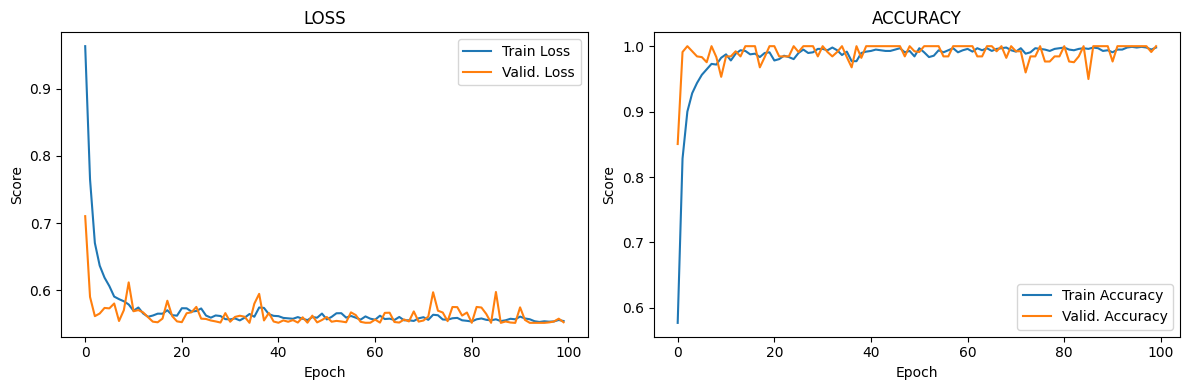

In [ ]:
plot_performance( results )

## Testing

This code defines a testing function (`testing_dataset`) for evaluating a PyTorch model on a given dataset. It computes and displays a confusion matrix, heatmap visualization, and classification report, providing metrics such as accuracy, precision, and recall to assess the model's performance in grading egg quality (Grade A, B, and C) based on color.

In [ ]:
# Fungsi untuk testing dataset
def testing_dataset(test_loader, model, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    i = 1
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            i = i + 1
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.tolist())
            all_labels.extend(labels.tolist())

    cm = confusion_matrix(all_labels, all_preds)

    # Visualisasi confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Mutu A', 'Mutu B', 'Mutu C'], yticklabels=['Mutu A', 'Mutu B', 'Mutu C'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print('\n')
    classification_rep = classification_report(all_labels, all_preds, digits=4)
    print('Laporan Klasifikasi:')
    print(classification_rep)

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    accuracy = accuracy_score(all_labels, all_preds)

    print('Akurasi: {:.2f}%'.format(accuracy * 100))
    print('Precision: {:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))

This code below is used for testing dataset (60 image files)

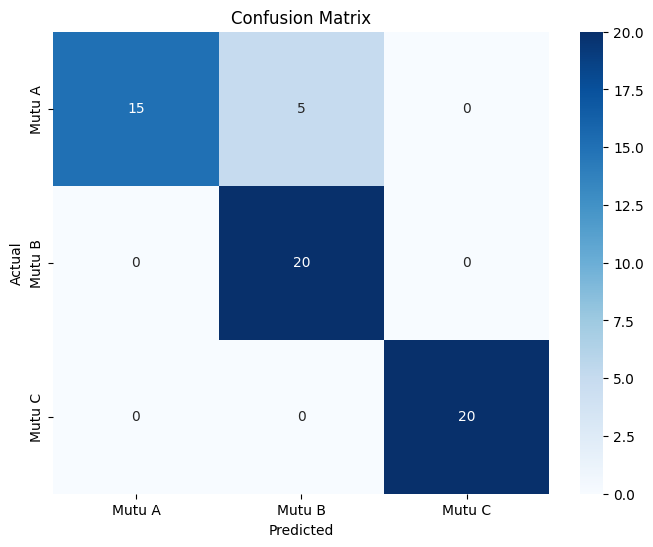



Laporan Klasifikasi:
              precision    recall  f1-score   support

           0     1.0000    0.7500    0.8571        20
           1     0.8000    1.0000    0.8889        20
           2     1.0000    1.0000    1.0000        20

    accuracy                         0.9167        60
   macro avg     0.9333    0.9167    0.9153        60
weighted avg     0.9333    0.9167    0.9153        60

Akurasi: 91.67%
Precision: 0.9333
Recall: 0.9167


In [ ]:
testing_transform = transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=mean, std=std)
    ])
testing = ImageFolder(root='/content/Testing', transform=testing_transform)
test_loader = DataLoader(testing, batch_size=1, shuffle=False)
testing_dataset(test_loader, model, device)

This code below is used for testing 10 image files out of dataset

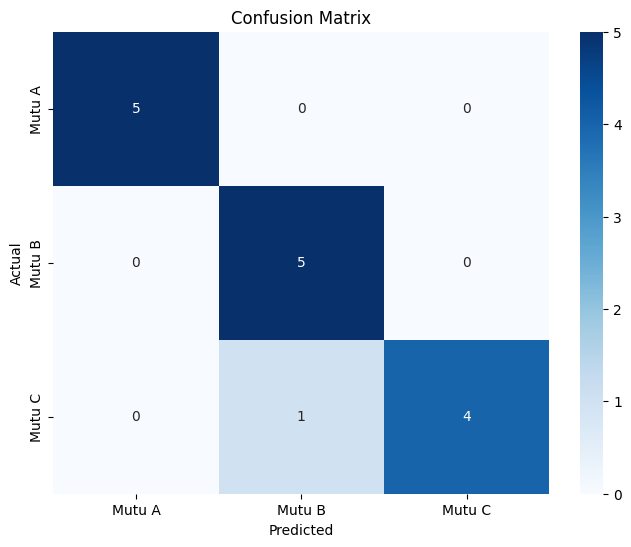



Laporan Klasifikasi:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         5
           1     0.8333    1.0000    0.9091         5
           2     1.0000    0.8000    0.8889         5

    accuracy                         0.9333        15
   macro avg     0.9444    0.9333    0.9327        15
weighted avg     0.9444    0.9333    0.9327        15

Akurasi: 93.33%
Precision: 0.9444
Recall: 0.9333


In [ ]:
testing_transform = transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=mean, std=std)
    ])
testing = ImageFolder(root='/content/Testing dari internet', transform=testing_transform)
test_loader = DataLoader(testing, batch_size=1, shuffle=False)
testing_dataset(test_loader, model,device)

This code is used for saving the models

In [ ]:
torch.save(model.state_dict(), "model-final.pth")